# Multi-Dataset Model Comparison
## Experiments on 4 Datasets with Type I Noise + Variable Label Noise
Pre-generated datasets contain Type I boundary noise (5%, 10%, 15%, 20%), and we inject label noise at various levels (0%, 5%, 10%, 15%, 20%, 25%, 30%)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datasets import inject_noise
from svm_models import NaiveSVM, ProbSVM, KNNSVM, SKiP
from multi_svm import OneVsRestSVM
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

In [2]:
# Dataset configurations
datasets_config = {
    'breast_cancer': {
        'clean': 'datasets/breast_cancer/breast_cancer.npz',
        'noisy': {
            '5%': 'datasets/breast_cancer/fast_breast_cancer_type1_boundary_5pct.npz',
            '10%': 'datasets/breast_cancer/fast_breast_cancer_type1_boundary_10pct.npz',
            '15%': 'datasets/breast_cancer/fast_breast_cancer_type1_boundary_15pct.npz',
            '20%': 'datasets/breast_cancer/fast_breast_cancer_type1_boundary_20pct.npz',
        }
    },
    'iris_2feat': {
        'clean': 'datasets/iris_2feat/iris_2feat.npz',
        'noisy': {
            '5%': 'datasets/iris_2feat/fast_iris_2feat_type1_boundary_5pct.npz',
            '10%': 'datasets/iris_2feat/fast_iris_2feat_type1_boundary_10pct.npz',
            '15%': 'datasets/iris_2feat/fast_iris_2feat_type1_boundary_15pct.npz',
            '20%': 'datasets/iris_2feat/fast_iris_2feat_type1_boundary_20pct.npz',
        }
    },
    'titanic': {
        'clean': 'datasets/titanic/titanic.npz',
        'noisy': {
            '5%': 'datasets/titanic/fast_titanic_type1_boundary_5pct.npz',
            '10%': 'datasets/titanic/fast_titanic_type1_boundary_10pct.npz',
            '15%': 'datasets/titanic/fast_titanic_type1_boundary_15pct.npz',
            '20%': 'datasets/titanic/fast_titanic_type1_boundary_20pct.npz',
        }
    },
    'wine': {
        'clean': 'datasets/wine/wine.npz',
        'noisy': {
            '5%': 'datasets/wine/fast_wine_type1_boundary_5pct.npz',
            '10%': 'datasets/wine/fast_wine_type1_boundary_10pct.npz',
            '15%': 'datasets/wine/fast_wine_type1_boundary_15pct.npz',
            '20%': 'datasets/wine/fast_wine_type1_boundary_20pct.npz',
        }
    }
}

# Label noise levels to inject at runtime
label_noise_levels = [0.0, 0.05, 0.10, 0.15, 0.20]

print("Dataset configurations loaded:")
for name in datasets_config.keys():
    print(f"  - {name}")
print(f"\nFeature noise levels (pre-generated): Clean, 5%, 10%, 15%, 20% (Type I boundary noise)")
print(f"Label noise levels (runtime injection): {[f'{int(n*100)}%' for n in label_noise_levels]}")

Dataset configurations loaded:
  - breast_cancer
  - iris_2feat
  - titanic
  - wine

Feature noise levels (pre-generated): Clean, 5%, 10%, 15%, 20% (Type I boundary noise)
Label noise levels (runtime injection): ['0%', '5%', '10%', '15%', '20%']


In [3]:
# Function to load and prepare data
def load_dataset(dataset_name, feature_noise_level=None, label_noise=0.0, random_state=42):
    """
    Load dataset from npz file and inject label noise.
    
    Parameters:
    - dataset_name: Name of the dataset ('breast_cancer', 'iris_2feat', 'titanic', 'wine')
    - feature_noise_level: None for clean data, or '5%', '10%', '15%', '20%' for pre-generated feature noise
    - label_noise: Proportion of labels to flip (0.0 to 1.0)
    - random_state: Random seed for reproducibility
    
    Returns:
    - X_train, X_test, y_train, y_test (all scaled)
    """
    if feature_noise_level is None:
        file_path = datasets_config[dataset_name]['clean']
    else:
        file_path = datasets_config[dataset_name]['noisy'][feature_noise_level]
    
    data = np.load(file_path)
    X = data['X_train']  # The full dataset is stored as X_train
    y = data['y_train']  # The full labels are stored as y_train
    
    # Inject label noise if needed
    if label_noise > 0:
        X, y = inject_noise(X, y, feature_noise=0.0, label_noise=label_noise, 
                           random_state=random_state, add_label_noise=False)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )
    
    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Test loading
dataset_name = 'wine'
X_train, X_test, y_train, y_test = load_dataset(dataset_name)
print(f"Test loading: {dataset_name}")
print(f"  Train: {X_train.shape}, Test: {X_test.shape}")
print(f"  Classes: {np.unique(y_train)}")
print(f"  Class distribution: {dict(zip(*np.unique(y_train, return_counts=True)))}")

# Test with label noise
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = load_dataset(
    dataset_name, feature_noise_level='10%', label_noise=0.10
)
print(f"\nTest loading with 10% feature noise + 10% label noise: {dataset_name}")
print(f"  Train: {X_train_noisy.shape}, Test: {X_test_noisy.shape}")

Test loading: wine
  Train: (142, 13), Test: (36, 13)
  Classes: [0 1 2]
  Class distribution: {np.int64(0): np.int64(47), np.int64(1): np.int64(57), np.int64(2): np.int64(38)}

Test loading with 10% feature noise + 10% label noise: wine
  Train: (390, 13), Test: (98, 13)


## 2. Experiment Configuration

In [4]:
# Hyperparameter configurations
C_values = [0.1, 1.0, 10.0, 100.0]
k_values = [5]
feature_noise_levels = [None, '5%', '10%', '15%', '20%']  # None = clean data

print("Experiment Configuration:")
print(f"  C values: {C_values}")
print(f"  k values (for KNNSVM/SKiP): {k_values}")
print(f"  Feature noise levels: {['Clean' if x is None else x for x in feature_noise_levels]}")
print(f"  Label noise levels: {[f'{int(n*100)}%' for n in label_noise_levels]}")
print(f"  Models: NaiveSVM, ProbSVM, KNNSVM, SKiP (multiply, multiply-minmax, average, average-minmax)")
print(f"  Kernel: Linear")
print(f"\nTotal experiments per dataset:")
num_base_models = len(C_values) * 2  # NaiveSVM, ProbSVM
num_knn_models = len(C_values) * len(k_values) * 5  # KNNSVM + 4 SKiP variants
total_per_noise_combo = num_base_models + num_knn_models
print(f"  Per feature-label noise combination: {total_per_noise_combo} experiments")
print(f"  Total per dataset: {total_per_noise_combo * len(feature_noise_levels) * len(label_noise_levels)} experiments")
print(f"  Grand total (4 datasets): {total_per_noise_combo * len(feature_noise_levels) * len(label_noise_levels) * 4} experiments")

Experiment Configuration:
  C values: [0.1, 1.0, 10.0, 100.0]
  k values (for KNNSVM/SKiP): [5]
  Feature noise levels: ['Clean', '5%', '10%', '15%', '20%']
  Label noise levels: ['0%', '5%', '10%', '15%', '20%']
  Models: NaiveSVM, ProbSVM, KNNSVM, SKiP (multiply, multiply-minmax, average, average-minmax)
  Kernel: Linear

Total experiments per dataset:
  Per feature-label noise combination: 28 experiments
  Total per dataset: 700 experiments
  Grand total (4 datasets): 2800 experiments


## 3. Run Experiments on All Datasets

In [5]:
# Main experiment function
def run_experiments(dataset_name, feature_noise_level=None, label_noise=0.0, random_state=42):
    """
    Run all model experiments on a specific dataset with given noise levels.
    
    Parameters:
    - dataset_name: Name of the dataset
    - feature_noise_level: None for clean data, or '5%', '10%', '15%', '20%' for pre-generated feature noise
    - label_noise: Proportion of labels to flip (0.0 to 1.0)
    - random_state: Random seed for reproducibility
    
    Returns:
    - List of result dictionaries
    """
    # Load data with feature noise and inject label noise
    X_train, X_test, y_train, y_test = load_dataset(dataset_name, feature_noise_level, label_noise, random_state)
    
    results = []
    feature_noise_str = "Clean" if feature_noise_level is None else feature_noise_level
    label_noise_str = f"{int(label_noise * 100)}%"
    
    print(f"\n{'='*70}")
    print(f"Dataset: {dataset_name} | Feature Noise: {feature_noise_str} | Label Noise: {label_noise_str}")
    print(f"{'='*70}")
    
    # Test each model with different C values
    for C in C_values:
        # NaiveSVM
        clf = OneVsRestSVM(NaiveSVM(C=C, kernel='linear', verbose=False))
        clf.fit(X_train, y_train)
        train_acc = (clf.predict(X_train) == y_train).mean()
        test_acc = (clf.predict(X_test) == y_test).mean()
        results.append({
            'Dataset': dataset_name,
            'Feature_Noise': feature_noise_str,
            'Label_Noise': label_noise_str,
            'Model': 'NaiveSVM',
            'C': C,
            'k': None,
            'Train Acc': train_acc,
            'Test Acc': test_acc
        })
        
        # ProbSVM
        clf = OneVsRestSVM(ProbSVM(C=C, kernel='linear', verbose=False))
        clf.fit(X_train, y_train)
        train_acc = (clf.predict(X_train) == y_train).mean()
        test_acc = (clf.predict(X_test) == y_test).mean()
        results.append({
            'Dataset': dataset_name,
            'Feature_Noise': feature_noise_str,
            'Label_Noise': label_noise_str,
            'Model': 'ProbSVM',
            'C': C,
            'k': None,
            'Train Acc': train_acc,
            'Test Acc': test_acc
        })
    
    # Test KNN-based models with different C and k values
    for C in C_values:
        for k in k_values:
            # KNNSVM
            clf = OneVsRestSVM(KNNSVM(C=C, k=k, kernel='linear', verbose=False))
            clf.fit(X_train, y_train)
            train_acc = (clf.predict(X_train) == y_train).mean()
            test_acc = (clf.predict(X_test) == y_test).mean()
            results.append({
                'Dataset': dataset_name,
                'Feature_Noise': feature_noise_str,
                'Label_Noise': label_noise_str,
                'Model': 'KNNSVM',
                'C': C,
                'k': k,
                'Train Acc': train_acc,
                'Test Acc': test_acc
            })
            
            # SKiP - multiply
            clf = OneVsRestSVM(SKiP(C=C, k=k, kernel='linear', verbose=False, combine_method='multiply'))
            clf.fit(X_train, y_train)
            train_acc = (clf.predict(X_train) == y_train).mean()
            test_acc = (clf.predict(X_test) == y_test).mean()
            results.append({
                'Dataset': dataset_name,
                'Feature_Noise': feature_noise_str,
                'Label_Noise': label_noise_str,
                'Model': 'SKiP-multiply',
                'C': C,
                'k': k,
                'Train Acc': train_acc,
                'Test Acc': test_acc
            })

            # SKiP - multiply (min-max scaling)
            clf = OneVsRestSVM(SKiP(C=C, k=k, kernel='linear', verbose=False, combine_method='multiply', scaling='minmax'))
            clf.fit(X_train, y_train)
            train_acc = (clf.predict(X_train) == y_train).mean()
            test_acc = (clf.predict(X_test) == y_test).mean()
            results.append({
                'Dataset': dataset_name,
                'Feature_Noise': feature_noise_str,
                'Label_Noise': label_noise_str,
                'Model': 'SKiP-multiply-minmax',
                'C': C,
                'k': k,
                'Train Acc': train_acc,
                'Test Acc': test_acc
            })

            # SKiP - average
            clf = OneVsRestSVM(SKiP(C=C, k=k, kernel='linear', verbose=False, combine_method='average'))
            clf.fit(X_train, y_train)
            train_acc = (clf.predict(X_train) == y_train).mean()
            test_acc = (clf.predict(X_test) == y_test).mean()
            results.append({
                'Dataset': dataset_name,
                'Feature_Noise': feature_noise_str,
                'Label_Noise': label_noise_str,
                'Model': 'SKiP-average',
                'C': C,
                'k': k,
                'Train Acc': train_acc,
                'Test Acc': test_acc
            })

            # SKiP - average (min-max scaling)
            clf = OneVsRestSVM(SKiP(C=C, k=k, kernel='linear', verbose=False, combine_method='average', scaling='minmax'))
            clf.fit(X_train, y_train)
            train_acc = (clf.predict(X_train) == y_train).mean()
            test_acc = (clf.predict(X_test) == y_test).mean()
            results.append({
                'Dataset': dataset_name,
                'Feature_Noise': feature_noise_str,
                'Label_Noise': label_noise_str,
                'Model': 'SKiP-average-minmax',
                'C': C,
                'k': k,
                'Train Acc': train_acc,
                'Test Acc': test_acc
            })
    
    print(f"Completed: {len(results)} experiments")
    return results

In [6]:
# Run ALL experiments on ALL datasets
all_results = []

for dataset_name in ['breast_cancer', 'iris_2feat', 'titanic', 'wine']:
    print(f"\n\n{'#'*70}")
    print(f"# DATASET: {dataset_name.upper()}")
    print(f"{'#'*70}")
    
    # Test all combinations of feature noise and label noise
    for feature_noise_level in feature_noise_levels:
        for label_noise in label_noise_levels:
            results = run_experiments(dataset_name, feature_noise_level, label_noise, random_state=42)
            all_results.extend(results)

# Convert to DataFrame
df_all_results = pd.DataFrame(all_results)
print(f"\n\n{'='*70}")
print(f"ALL EXPERIMENTS COMPLETED")
print(f"{'='*70}")
print(f"Total experiments: {len(df_all_results)}")
print(f"Datasets: {df_all_results['Dataset'].nunique()}")
print(f"Models: {df_all_results['Model'].nunique()}")
print(f"Feature noise levels: {df_all_results['Feature_Noise'].nunique()}")
print(f"Label noise levels: {df_all_results['Label_Noise'].nunique()}")

# Display sample results
print(f"\nSample results:")
print(df_all_results.head(10))



######################################################################
# DATASET: BREAST_CANCER
######################################################################

Dataset: breast_cancer | Feature Noise: Clean | Label Noise: 0%
Completed: 28 experiments

Dataset: breast_cancer | Feature Noise: Clean | Label Noise: 5%
Completed: 28 experiments

Dataset: breast_cancer | Feature Noise: Clean | Label Noise: 10%
Completed: 28 experiments

Dataset: breast_cancer | Feature Noise: Clean | Label Noise: 15%
Completed: 28 experiments

Dataset: breast_cancer | Feature Noise: Clean | Label Noise: 20%
Completed: 28 experiments

Dataset: breast_cancer | Feature Noise: 5% | Label Noise: 0%
Completed: 28 experiments

Dataset: breast_cancer | Feature Noise: 5% | Label Noise: 5%
Completed: 28 experiments

Dataset: breast_cancer | Feature Noise: 5% | Label Noise: 10%
Completed: 28 experiments

Dataset: breast_cancer | Feature Noise: 5% | Label Noise: 15%
Completed: 28 experiments

Dataset: breast_ca

## 4. Results Analysis and Visualization

### 4.1 Save Results to CSV

In [7]:
# Save results to CSV
output_filename = 'model_comparison_results.csv'
df_all_results.to_csv(output_filename, index=False)
print(f"Results saved to {output_filename}")

# Display basic statistics
print(f"\nDataset statistics:")
print(df_all_results.groupby('Dataset').size())
print(f"\nModel statistics:")
print(df_all_results.groupby('Model').size())

Results saved to model_comparison_results.csv

Dataset statistics:
Dataset
breast_cancer    700
iris_2feat       700
titanic          700
wine             700
dtype: int64

Model statistics:
Model
KNNSVM                  400
NaiveSVM                400
ProbSVM                 400
SKiP-average            400
SKiP-average-minmax     400
SKiP-multiply           400
SKiP-multiply-minmax    400
dtype: int64


### 4.2 Best Model Selection per Dataset

In [8]:
# Find best performing configuration for each dataset and noise combination
best_results = df_all_results.loc[df_all_results.groupby(['Dataset', 'Feature_Noise', 'Label_Noise'])['Test Acc'].idxmax()]

print("=" * 80)
print("BEST MODEL FOR EACH DATASET AND NOISE COMBINATION")
print("=" * 80)
for dataset in best_results['Dataset'].unique():
    print(f"\n{dataset.upper()}:")
    dataset_best = best_results[best_results['Dataset'] == dataset]
    for _, row in dataset_best.iterrows():
        print(f"  Feature Noise: {row['Feature_Noise']:5s} | Label Noise: {row['Label_Noise']:3s} | "
              f"Model: {row['Model']:20s} | C: {row['C']:8.1f} | k: {str(row['k']):4s} | "
              f"Test Acc: {row['Test Acc']:.4f}")

BEST MODEL FOR EACH DATASET AND NOISE COMBINATION

BREAST_CANCER:
  Feature Noise: 10%   | Label Noise: 0%  | Model: NaiveSVM             | C:      0.1 | k: nan  | Test Acc: 0.9255
  Feature Noise: 10%   | Label Noise: 10% | Model: NaiveSVM             | C:      0.1 | k: nan  | Test Acc: 0.8261
  Feature Noise: 10%   | Label Noise: 15% | Model: KNNSVM               | C:      0.1 | k: 5.0  | Test Acc: 0.8012
  Feature Noise: 10%   | Label Noise: 20% | Model: NaiveSVM             | C:    100.0 | k: nan  | Test Acc: 0.7578
  Feature Noise: 10%   | Label Noise: 5%  | Model: NaiveSVM             | C:      1.0 | k: nan  | Test Acc: 0.8944
  Feature Noise: 15%   | Label Noise: 0%  | Model: SKiP-average         | C:      0.1 | k: 5.0  | Test Acc: 0.8956
  Feature Noise: 15%   | Label Noise: 10% | Model: KNNSVM               | C:      0.1 | k: 5.0  | Test Acc: 0.8516
  Feature Noise: 15%   | Label Noise: 15% | Model: SKiP-average         | C:     10.0 | k: 5.0  | Test Acc: 0.7637
  Feature Nois

### 4.3 Model Performance Comparison Across Datasets

AVERAGE PERFORMANCE ACROSS ALL DATASETS (CLEAN DATA)
               Model  Avg Test Acc
 SKiP-average-minmax      0.884208
        SKiP-average      0.884208
              KNNSVM      0.877271
            NaiveSVM      0.873081
       SKiP-multiply      0.788944
             ProbSVM      0.780611
SKiP-multiply-minmax      0.772277


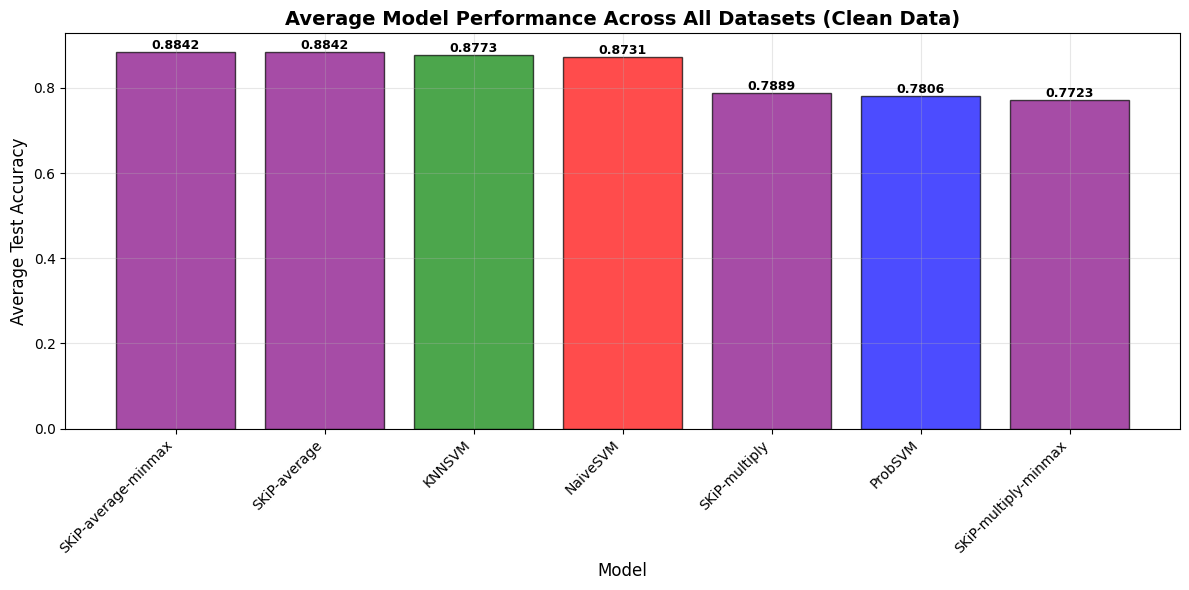

In [9]:
# Compare average performance across all datasets for clean data
clean_data = df_all_results[(df_all_results['Feature_Noise'] == 'Clean') & 
                            (df_all_results['Label_Noise'] == '0%')]

# Get best C for each model
model_avg_performance = []
for model in clean_data['Model'].unique():
    model_data = clean_data[clean_data['Model'] == model]
    best_by_dataset = model_data.loc[model_data.groupby('Dataset')['Test Acc'].idxmax()]
    avg_test_acc = best_by_dataset['Test Acc'].mean()
    model_avg_performance.append({
        'Model': model,
        'Avg Test Acc': avg_test_acc
    })

perf_df = pd.DataFrame(model_avg_performance).sort_values('Avg Test Acc', ascending=False)

print("=" * 60)
print("AVERAGE PERFORMANCE ACROSS ALL DATASETS (CLEAN DATA)")
print("=" * 60)
print(perf_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['red' if 'Naive' in m else 'blue' if 'Prob' in m else 'green' if 'KNN' in m else 'purple' 
          for m in perf_df['Model']]
bars = ax.bar(range(len(perf_df)), perf_df['Avg Test Acc'], color=colors, alpha=0.7, edgecolor='black')

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, perf_df['Avg Test Acc'])):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{acc:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylabel('Average Test Accuracy', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.set_title('Average Model Performance Across All Datasets (Clean Data)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(perf_df)))
ax.set_xticklabels(perf_df['Model'], rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 4.4 Noise Robustness Analysis: Heatmaps

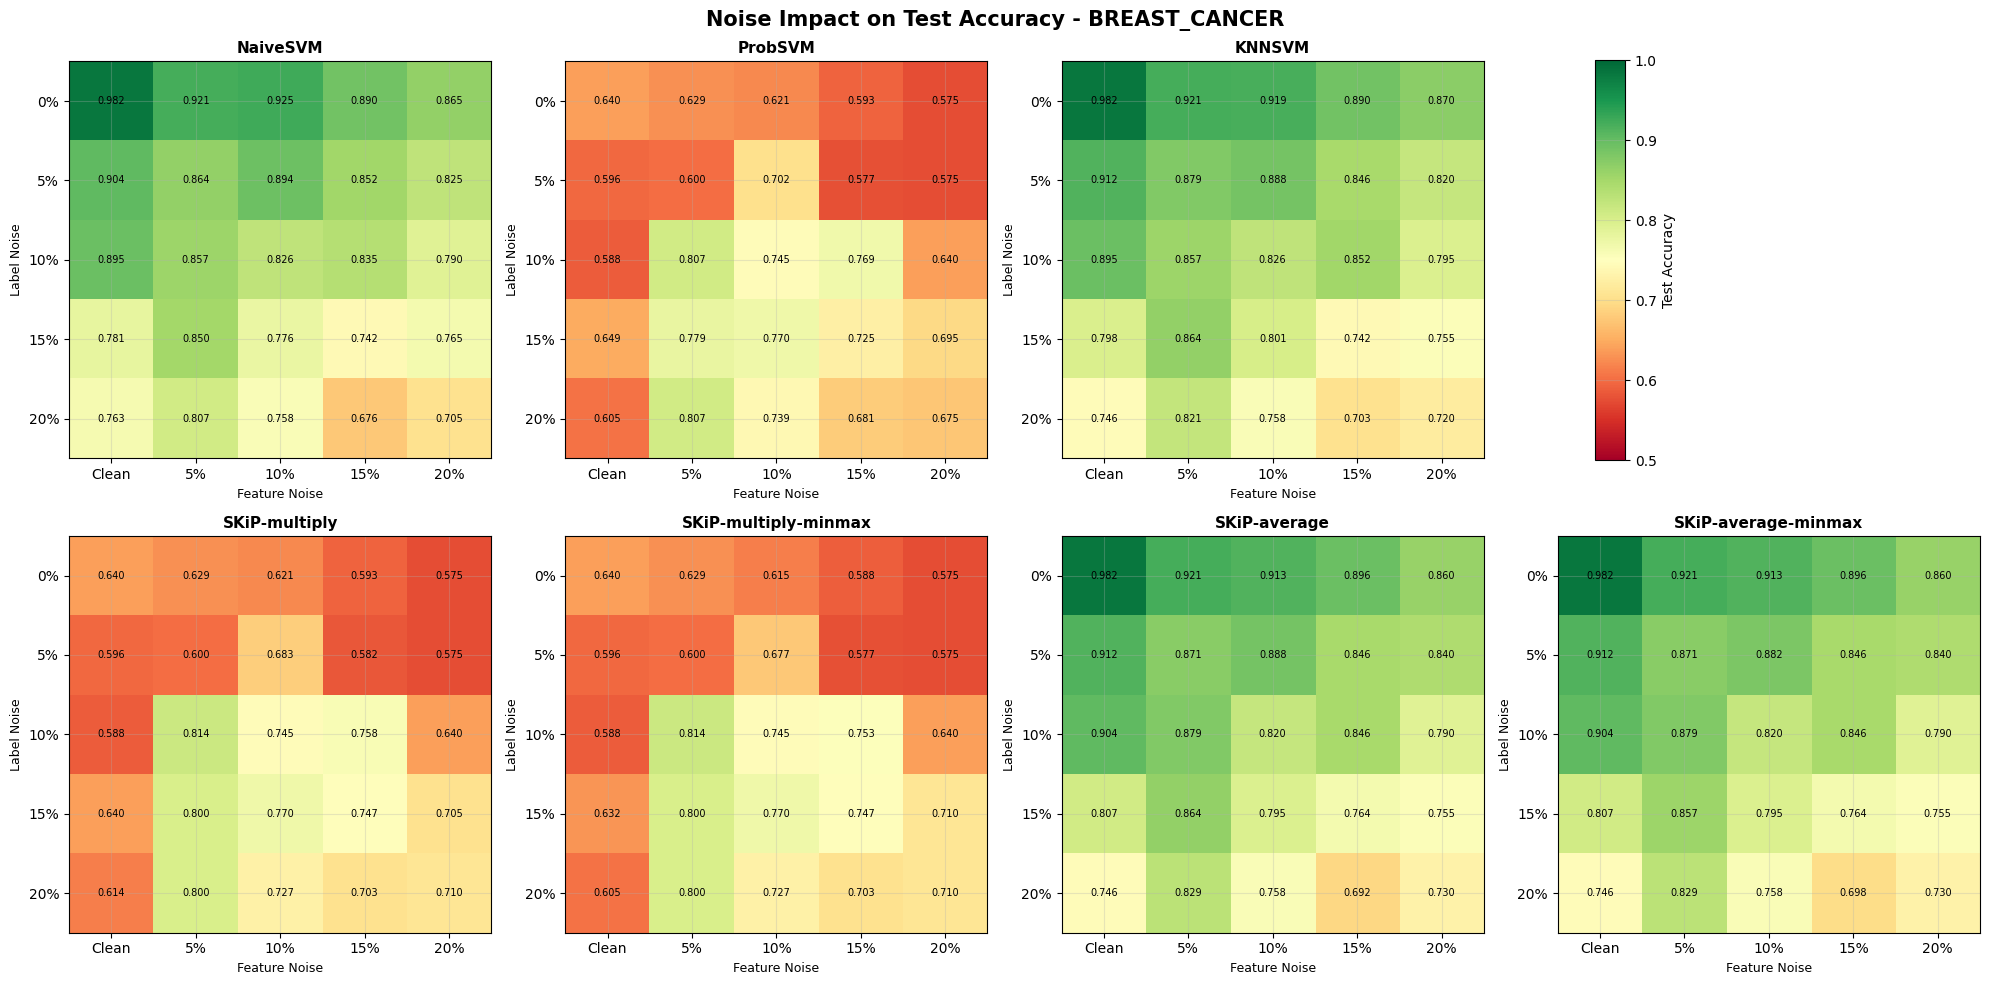

Saved heatmap for breast_cancer


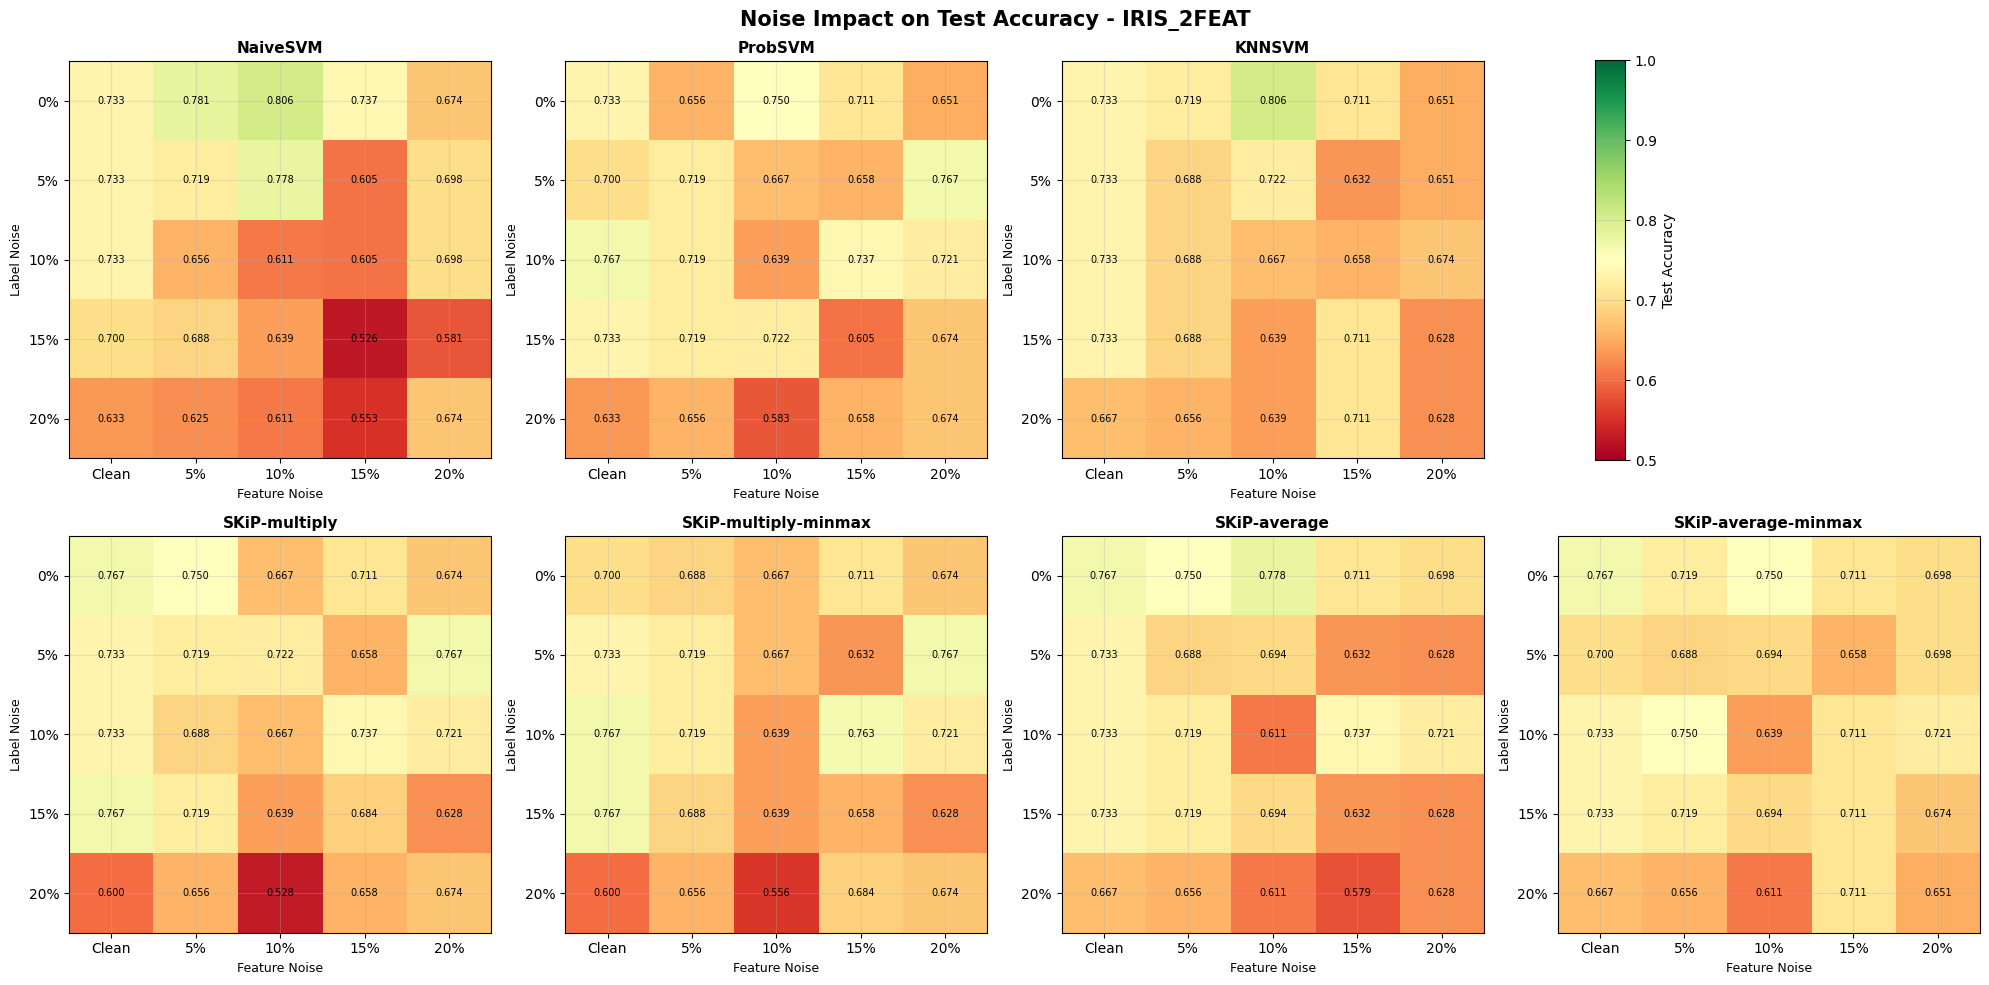

Saved heatmap for iris_2feat


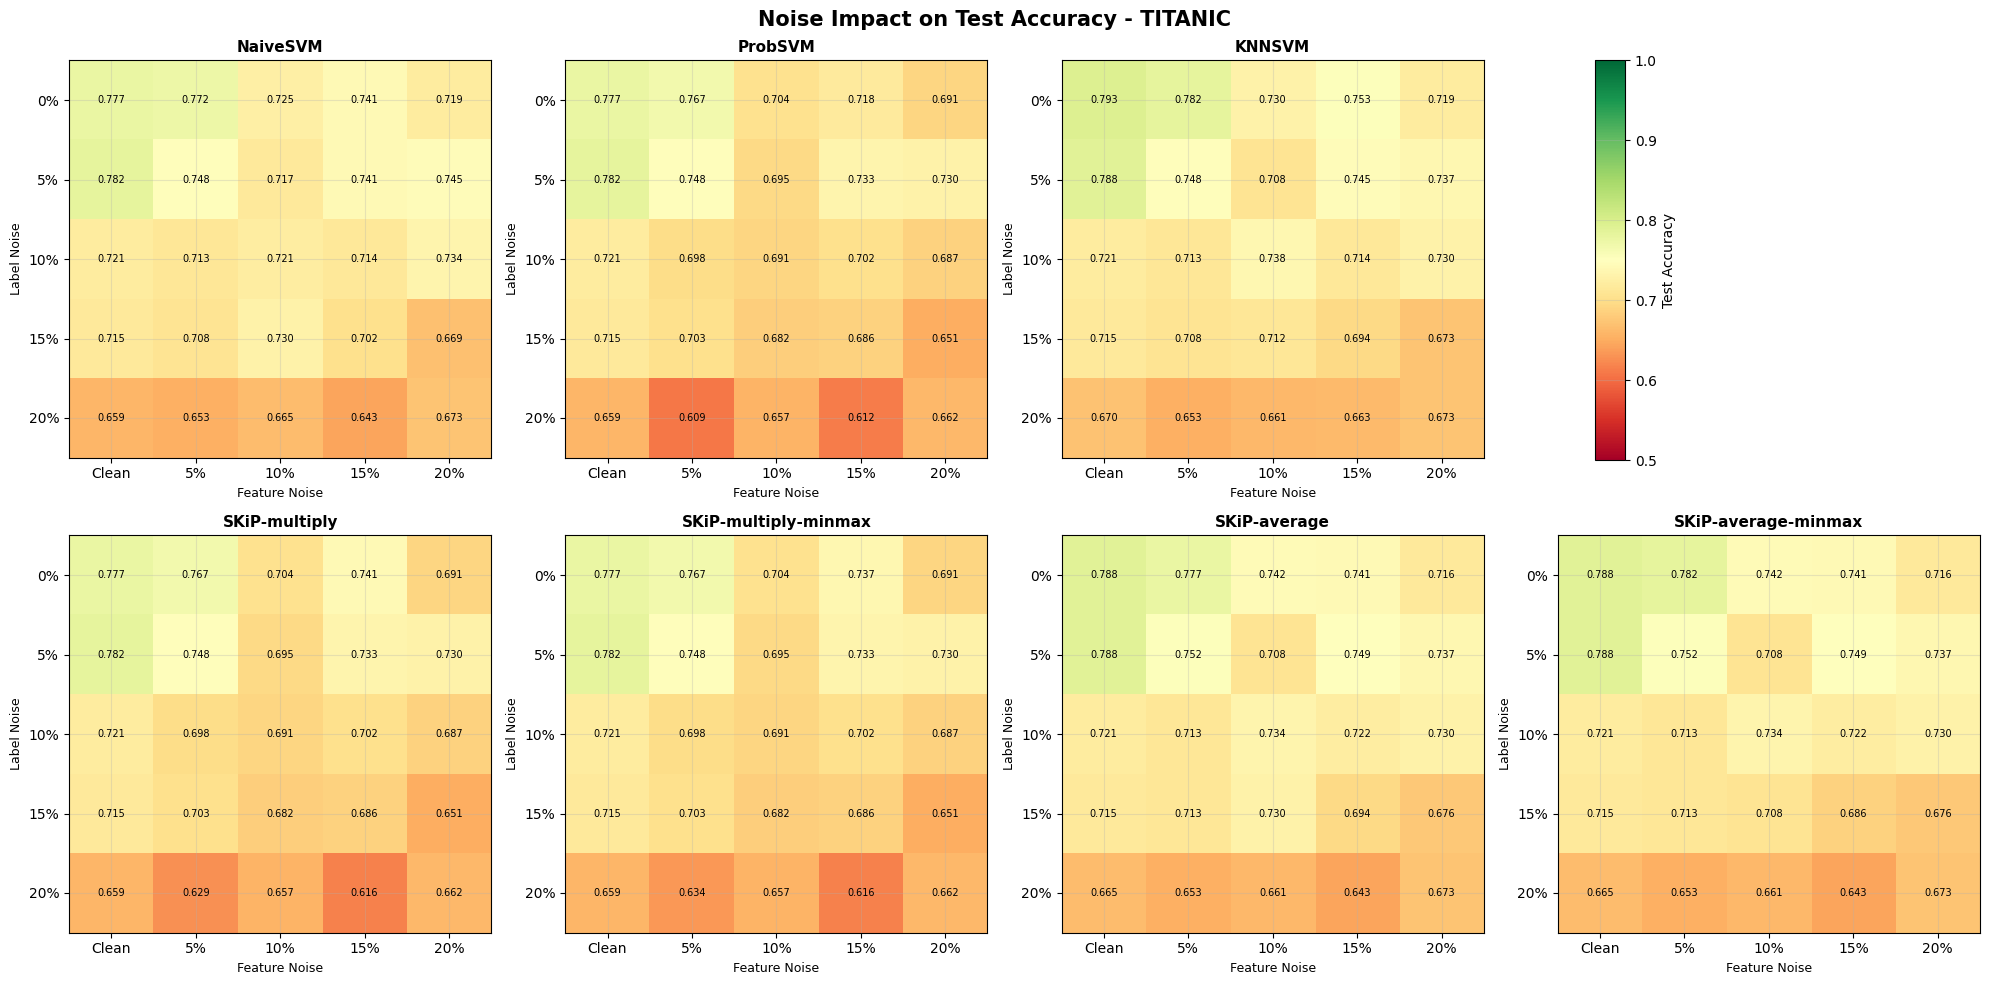

Saved heatmap for titanic


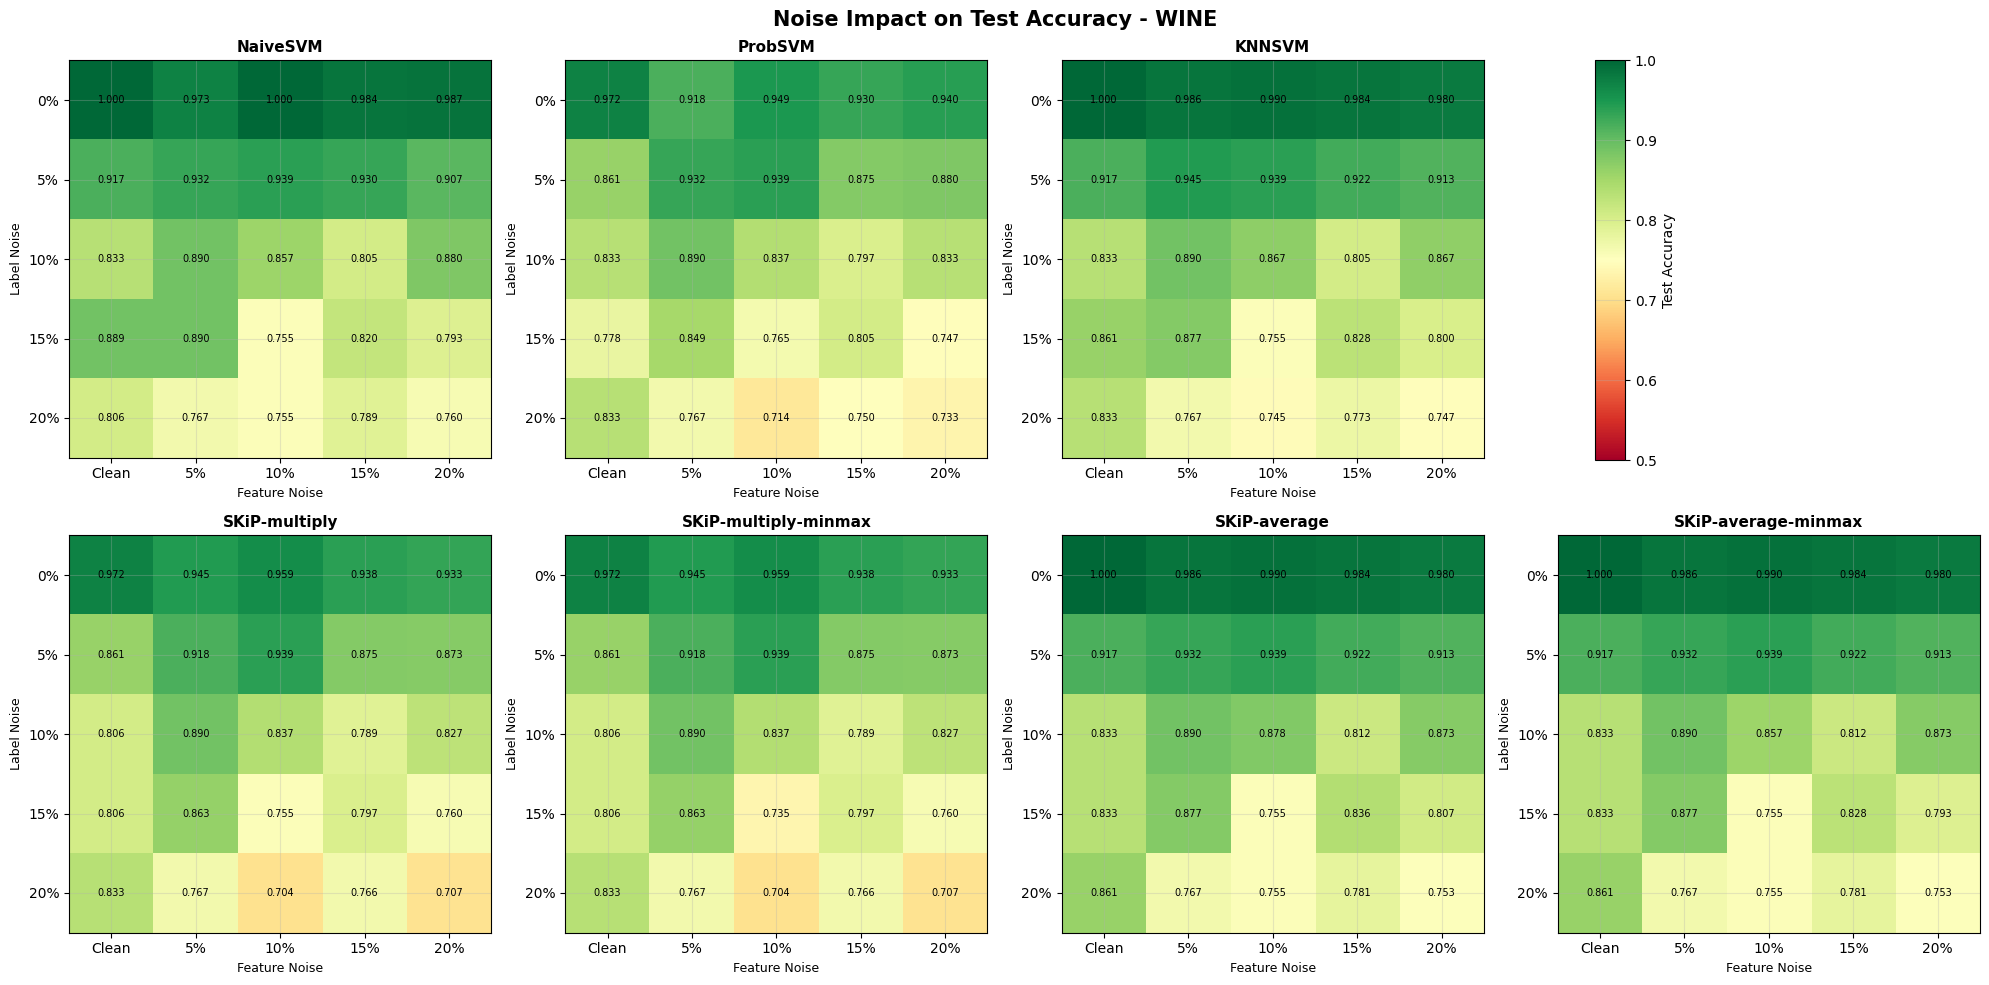

Saved heatmap for wine


In [36]:
# Create heatmaps for each dataset showing noise impact on best model performance
for dataset_name in ['breast_cancer', 'iris_2feat', 'titanic', 'wine']:
    dataset_results = df_all_results[df_all_results['Dataset'] == dataset_name]
    
    # Get best performance for each noise combination and model
    best_per_combo = dataset_results.loc[
        dataset_results.groupby(['Feature_Noise', 'Label_Noise', 'Model'])['Test Acc'].idxmax()
    ]
    
    # Focus on main models - include all SKiP variants
    main_models = ['NaiveSVM', 'ProbSVM', 'KNNSVM', None,
                   'SKiP-multiply', 'SKiP-multiply-minmax',
                   'SKiP-average', 'SKiP-average-minmax']
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    
    for idx, model in enumerate(main_models):
        if model is None:
            axes[idx].set_visible(False)
            continue
        
        model_data = best_per_combo[best_per_combo['Model'] == model]
        
        # Create pivot table
        pivot = model_data.pivot_table(
            values='Test Acc',
            index='Label_Noise',
            columns='Feature_Noise',
            aggfunc='mean'
        )
        
        # Reorder columns and index
        feature_order = ['Clean', '5%', '10%', '15%', '20%']
        label_order = ['0%', '5%', '10%', '15%', '20%']
        pivot = pivot.reindex(index=label_order, columns=feature_order)
        
        # Plot heatmap
        ax = axes[idx]
        im = ax.imshow(pivot.values, cmap='RdYlGn', aspect='auto', vmin=0.5, vmax=1.0)
        
        # Set ticks
        ax.set_xticks(range(len(feature_order)))
        ax.set_yticks(range(len(label_order)))
        ax.set_xticklabels(feature_order)
        ax.set_yticklabels(label_order)
        
        # Add text annotations
        for i in range(len(label_order)):
            for j in range(len(feature_order)):
                if not np.isnan(pivot.values[i, j]):
                    text = ax.text(j, i, f'{pivot.values[i, j]:.3f}',
                                 ha='center', va='center', color='black', fontsize=7)
        
        ax.set_title(f'{model}', fontsize=11, fontweight='bold')
        ax.set_xlabel('Feature Noise', fontsize=9)
        ax.set_ylabel('Label Noise', fontsize=9)
    
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.80, 0.53, 0.015, 0.4])  
    fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='Test Accuracy')
    
    plt.suptitle(f'Noise Impact on Test Accuracy - {dataset_name.upper()}', 
                 fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'noise_heatmap_{dataset_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved heatmap for {dataset_name}")

### 4.5 Performance Degradation Analysis

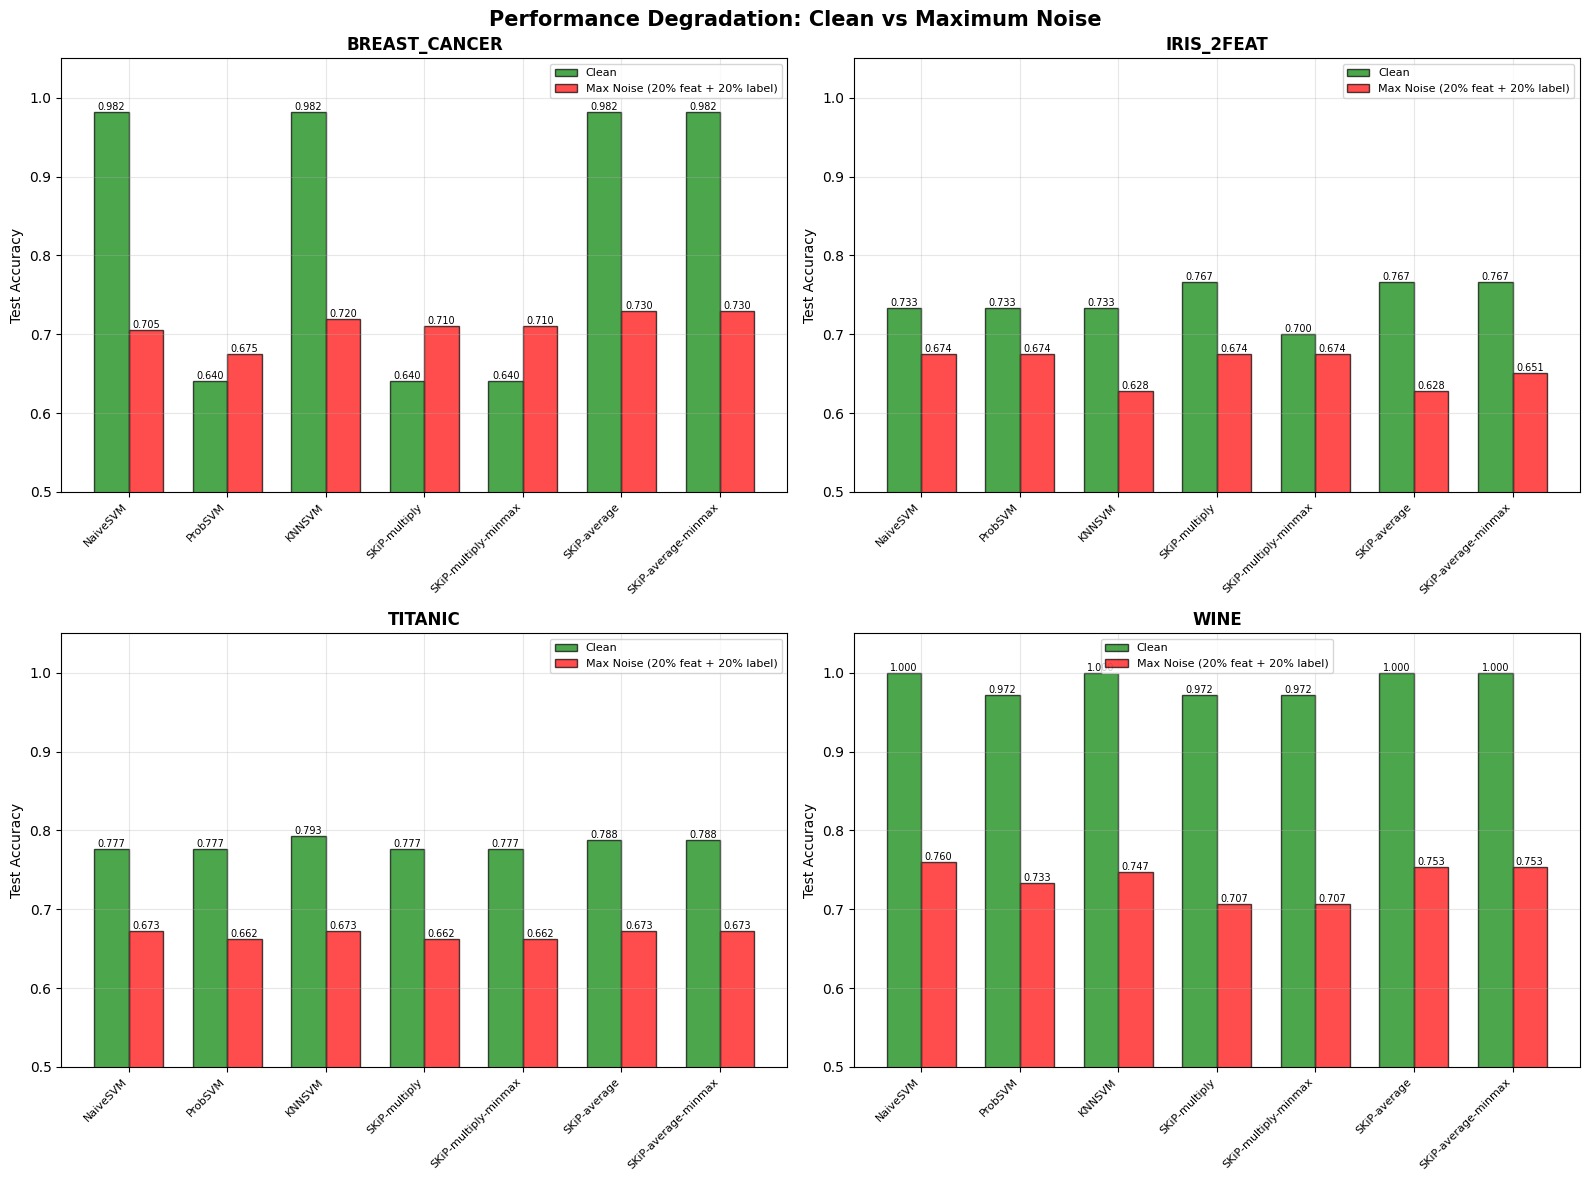


PERFORMANCE DEGRADATION SUMMARY

BREAST_CANCER:
               Model  Clean Acc  Max Noise Acc  Degradation  Degradation %
       SKiP-multiply   0.640351          0.710    -0.069649     -10.876712
SKiP-multiply-minmax   0.640351          0.710    -0.069649     -10.876712
             ProbSVM   0.640351          0.675    -0.034649      -5.410959
        SKiP-average   0.982456          0.730     0.252456      25.696429
 SKiP-average-minmax   0.982456          0.730     0.252456      25.696429
              KNNSVM   0.982456          0.720     0.262456      26.714286
            NaiveSVM   0.982456          0.705     0.277456      28.241071

Most robust model: SKiP-multiply

IRIS_2FEAT:
               Model  Clean Acc  Max Noise Acc  Degradation  Degradation %
SKiP-multiply-minmax   0.700000       0.674419     0.025581       3.654485
            NaiveSVM   0.733333       0.674419     0.058915       8.033827
             ProbSVM   0.733333       0.674419     0.058915       8.033827
    

In [38]:
# Calculate performance degradation from clean to noisy data
degradation_analysis = []

for dataset in df_all_results['Dataset'].unique():
    # Get clean baseline (no feature noise, no label noise)
    clean_baseline = df_all_results[
        (df_all_results['Dataset'] == dataset) & 
        (df_all_results['Feature_Noise'] == 'Clean') & 
        (df_all_results['Label_Noise'] == '0%')
    ]
    
    # Get maximum noise (20% feature, 30% label)
    max_noise = df_all_results[
        (df_all_results['Dataset'] == dataset) & 
        (df_all_results['Feature_Noise'] == '20%') & 
        (df_all_results['Label_Noise'] == '20%')
    ]
    
    for model in clean_baseline['Model'].unique():
        clean_acc = clean_baseline[clean_baseline['Model'] == model]['Test Acc'].max()
        noisy_acc = max_noise[max_noise['Model'] == model]['Test Acc'].max()
        degradation = clean_acc - noisy_acc
        
        degradation_analysis.append({
            'Dataset': dataset,
            'Model': model,
            'Clean Acc': clean_acc,
            'Max Noise Acc': noisy_acc,
            'Degradation': degradation,
            'Degradation %': (degradation / clean_acc) * 100
        })

degradation_df = pd.DataFrame(degradation_analysis)

# Visualize degradation - include all SKiP variants
models_to_plot = ['NaiveSVM', 'ProbSVM', 'KNNSVM', 
                  'SKiP-multiply', 'SKiP-multiply-minmax', 
                  'SKiP-average', 'SKiP-average-minmax']
plot_data = degradation_df[degradation_df['Model'].isin(models_to_plot)]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, dataset in enumerate(['breast_cancer', 'iris_2feat', 'titanic', 'wine']):
    ax = axes[idx]
    dataset_data = plot_data[plot_data['Dataset'] == dataset]
    
    x = np.arange(len(models_to_plot))
    width = 0.35
    
    clean_accs = [dataset_data[dataset_data['Model'] == m]['Clean Acc'].values[0] 
                  for m in models_to_plot]
    noisy_accs = [dataset_data[dataset_data['Model'] == m]['Max Noise Acc'].values[0] 
                  for m in models_to_plot]
    
    bars1 = ax.bar(x - width/2, clean_accs, width, label='Clean', 
                   color='green', alpha=0.7, edgecolor='black')
    bars2 = ax.bar(x + width/2, noisy_accs, width, label='Max Noise (20% feat + 20% label)',
                   color='red', alpha=0.7, edgecolor='black')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=7)
    
    ax.set_ylabel('Test Accuracy', fontsize=10)
    ax.set_title(f'{dataset.upper()}', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models_to_plot, rotation=45, ha='right', fontsize=8)
    ax.legend(fontsize=8)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0.5, 1.05])

plt.suptitle('Performance Degradation: Clean vs Maximum Noise', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('performance_degradation.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "=" * 80)
print("PERFORMANCE DEGRADATION SUMMARY")
print("=" * 80)
for dataset in degradation_df['Dataset'].unique():
    print(f"\n{dataset.upper()}:")
    dataset_deg = degradation_df[degradation_df['Dataset'] == dataset].sort_values('Degradation')
    print(dataset_deg[['Model', 'Clean Acc', 'Max Noise Acc', 'Degradation', 'Degradation %']].to_string(index=False))
    print(f"\nMost robust model: {dataset_deg.iloc[0]['Model']}")

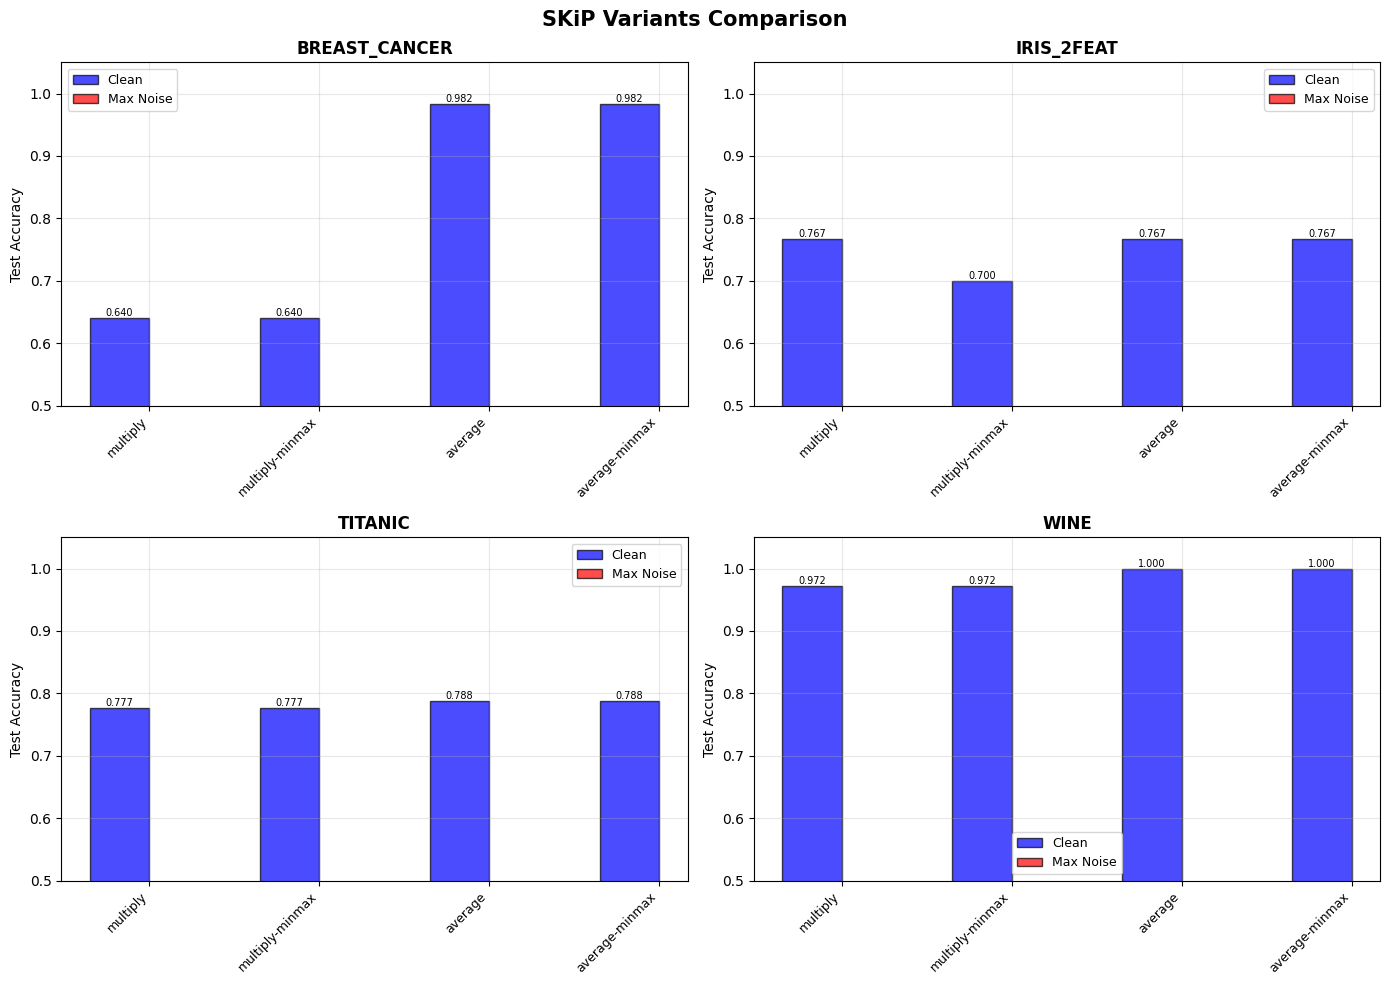


SKiP VARIANTS COMPARISON SUMMARY

BREAST_CANCER:
             Variant    Clean  Max Noise  Degradation
       SKiP-multiply 0.640351        NaN          NaN
SKiP-multiply-minmax 0.640351        NaN          NaN
        SKiP-average 0.982456        NaN          NaN
 SKiP-average-minmax 0.982456        NaN          NaN

Most robust variant: SKiP-multiply
Best clean performance: SKiP-average

IRIS_2FEAT:
             Variant    Clean  Max Noise  Degradation
       SKiP-multiply 0.766667        NaN          NaN
SKiP-multiply-minmax 0.700000        NaN          NaN
        SKiP-average 0.766667        NaN          NaN
 SKiP-average-minmax 0.766667        NaN          NaN

Most robust variant: SKiP-multiply
Best clean performance: SKiP-multiply

TITANIC:
             Variant    Clean  Max Noise  Degradation
       SKiP-multiply 0.776536        NaN          NaN
SKiP-multiply-minmax 0.776536        NaN          NaN
        SKiP-average 0.787709        NaN          NaN
 SKiP-average-minmax 0.7

In [14]:
# Compare different SKiP variants
skip_variants = ['SKiP-multiply', 'SKiP-multiply-minmax', 'SKiP-average', 'SKiP-average-minmax']

# Get best performance for each variant across all datasets
variant_comparison = []
for dataset in df_all_results['Dataset'].unique():
    for variant in skip_variants:
        variant_data = df_all_results[
            (df_all_results['Dataset'] == dataset) & 
            (df_all_results['Model'] == variant)
        ]
        
        # Clean data performance
        clean_perf = variant_data[
            (variant_data['Feature_Noise'] == 'Clean') & 
            (variant_data['Label_Noise'] == '0%')
        ]['Test Acc'].max()
        
        # Maximum noise performance
        max_noise_perf = variant_data[
            (variant_data['Feature_Noise'] == '20%') & 
            (variant_data['Label_Noise'] == '30%')
        ]['Test Acc'].max()
        
        variant_comparison.append({
            'Dataset': dataset,
            'Variant': variant,
            'Clean': clean_perf,
            'Max Noise': max_noise_perf,
            'Degradation': clean_perf - max_noise_perf
        })

variant_df = pd.DataFrame(variant_comparison)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, dataset in enumerate(['breast_cancer', 'iris_2feat', 'titanic', 'wine']):
    ax = axes[idx]
    dataset_variants = variant_df[variant_df['Dataset'] == dataset]
    
    x = np.arange(len(skip_variants))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, dataset_variants['Clean'], width, 
                   label='Clean', color='blue', alpha=0.7, edgecolor='black')
    bars2 = ax.bar(x + width/2, dataset_variants['Max Noise'], width,
                   label='Max Noise', color='red', alpha=0.7, edgecolor='black')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=7)
    
    ax.set_ylabel('Test Accuracy', fontsize=10)
    ax.set_title(f'{dataset.upper()}', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([v.replace('SKiP-', '') for v in skip_variants], 
                       rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0.5, 1.05])

plt.suptitle('SKiP Variants Comparison', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('skip_variants_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "=" * 80)
print("SKiP VARIANTS COMPARISON SUMMARY")
print("=" * 80)
for dataset in variant_df['Dataset'].unique():
    print(f"\n{dataset.upper()}:")
    dataset_var = variant_df[variant_df['Dataset'] == dataset].sort_values('Degradation')
    print(dataset_var[['Variant', 'Clean', 'Max Noise', 'Degradation']].to_string(index=False))
    print(f"\nMost robust variant: {dataset_var.iloc[0]['Variant']}")
    print(f"Best clean performance: {dataset_var.loc[dataset_var['Clean'].idxmax(), 'Variant']}")

### 4.8 Overall Best Model Across All Conditions

OVERALL MODEL PERFORMANCE ACROSS ALL CONDITIONS
               Model  Mean Acc  Std Acc  Min Acc  Max Acc
 SKiP-average-minmax  0.781131 0.095789 0.611111 1.000000
        SKiP-average  0.778701 0.100902 0.578947 1.000000
              KNNSVM  0.777918 0.099199 0.627907 1.000000
            NaiveSVM  0.772914 0.106750 0.526316 1.000000
       SKiP-multiply  0.727699 0.094631 0.527778 0.972222
             ProbSVM  0.726445 0.093601 0.575000 0.972222
SKiP-multiply-minmax  0.725577 0.095215 0.555556 0.972222


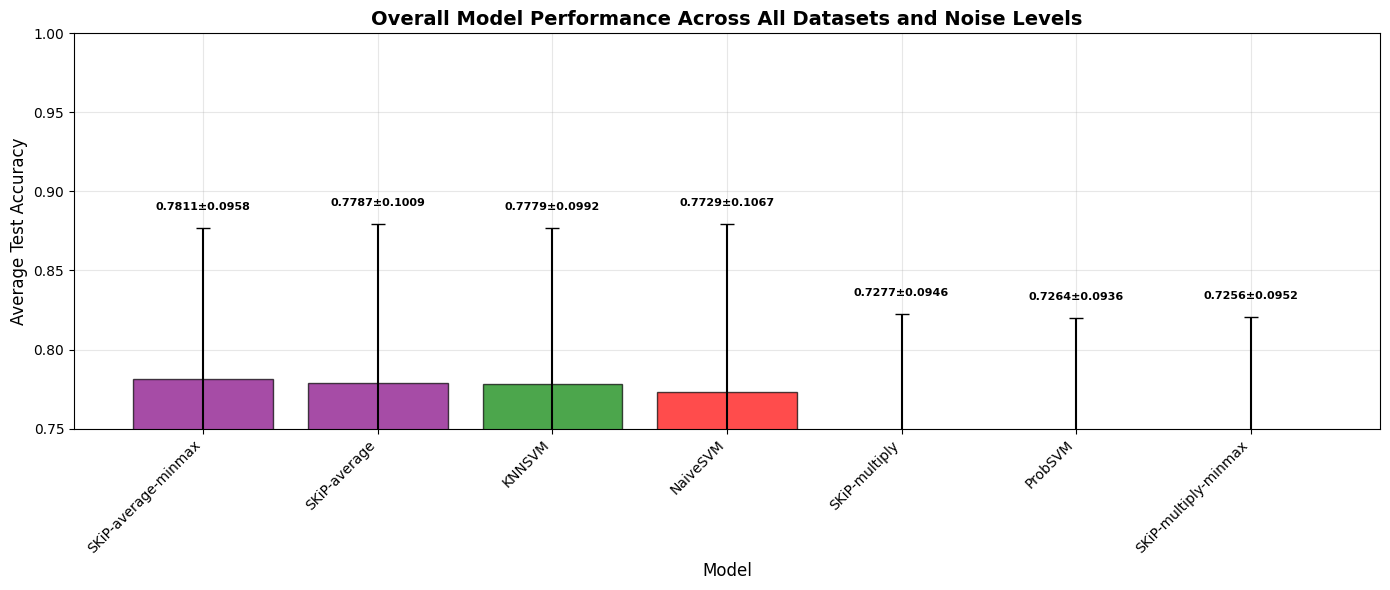


✓ Best overall model: SKiP-average-minmax
✓ Most consistent model (lowest std): ProbSVM
✓ Highest peak performance: SKiP-average-minmax


In [15]:
# Calculate average performance across all noise conditions for each model
overall_performance = []

for model in df_all_results['Model'].unique():
    model_data = df_all_results[df_all_results['Model'] == model]
    
    # Get best performance for each dataset/noise combination
    best_per_combo = model_data.loc[model_data.groupby(['Dataset', 'Feature_Noise', 'Label_Noise'])['Test Acc'].idxmax()]
    
    avg_performance = best_per_combo['Test Acc'].mean()
    std_performance = best_per_combo['Test Acc'].std()
    min_performance = best_per_combo['Test Acc'].min()
    max_performance = best_per_combo['Test Acc'].max()
    
    overall_performance.append({
        'Model': model,
        'Mean Acc': avg_performance,
        'Std Acc': std_performance,
        'Min Acc': min_performance,
        'Max Acc': max_performance
    })

overall_df = pd.DataFrame(overall_performance).sort_values('Mean Acc', ascending=False)

print("=" * 80)
print("OVERALL MODEL PERFORMANCE ACROSS ALL CONDITIONS")
print("=" * 80)
print(overall_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))

models_sorted = overall_df['Model'].values
means = overall_df['Mean Acc'].values
stds = overall_df['Std Acc'].values

x = np.arange(len(models_sorted))
colors = ['red' if 'Naive' in m else 'blue' if 'Prob' in m else 'green' if 'KNN' in m else 'purple' 
          for m in models_sorted]

bars = ax.bar(x, means, yerr=stds, capsize=5, color=colors, alpha=0.7, edgecolor='black')

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    ax.text(bar.get_x() + bar.get_width()/2., mean + std + 0.01,
            f'{mean:.4f}±{std:.4f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

ax.set_ylabel('Average Test Accuracy', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.set_title('Overall Model Performance Across All Datasets and Noise Levels', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models_sorted, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.75, 1.0])

plt.tight_layout()
plt.savefig('overall_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Best overall model: {overall_df.iloc[0]['Model']}")
print(f"✓ Most consistent model (lowest std): {overall_df.loc[overall_df['Std Acc'].idxmin(), 'Model']}")
print(f"✓ Highest peak performance: {overall_df.loc[overall_df['Max Acc'].idxmax(), 'Model']}")